#Connections Visualization

In [651]:
#@title Pairwise distances
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_hello(N=1000, rseed=42):
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))

import numpy as np

# arrange "hello" in non-linear, S-shaped way
def make_hello_s_curve(X):
  t = (X[:, 0] - 2) * 0.75 * np.pi
  x = np.sin(t)
  y = X[:, 1]
  z = np.sign(t) * (np.cos(t) - 1)
  return np.vstack((x, y, z)).T
XS = make_hello_s_curve(X)

from plotly.subplots import make_subplots
import plotly.graph_objects as go
colors = ['rgb(' + np.array2string(c[:-1], formatter={'float_kind':lambda x:  "%.0f" % (x * 255)}, separator=',')[1:-1] + ')' for c in colorize['cmap'](0.255*colorize['c'])]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])

fig.add_trace(go.Scatter3d(x=XS[:, 0], y=XS[:, 1], z=XS[:, 2],
                           mode='markers', name='datapoints (LEFT)',
                           marker=dict(
                              size=5,
                              opacity=0.8,
                              color=colors
                            )
                           ), row=1, col=1)
fig.add_trace(go.Scatter3d(x=XS[:, 0], y=XS[:, 1], z=XS[:, 2],
                           mode='markers', name='datapoints (RIGHT)',
                           marker=dict(
                              size=5,
                              opacity=0.8,
                              color=colors
                            )
                           ), row=1, col=2)

# construct lines for LLE
from sklearn.neighbors import NearestNeighbors

N_neighbours = 100

rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
nbrs = NearestNeighbors(n_neighbors=N_neighbours, radius=100.0).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = []
for i in range(100):
  for j in nbrs[i]:
    lines_LLE = lines_LLE + [XS[ind[i]], XS[j], np.array([None, None, None])]
lines_LLE = np.array(lines_LLE)

fig.add_trace(go.Scatter3d(
    x=lines_LLE[:, 0],
    y=lines_LLE[:, 1],
    z=lines_LLE[:, 2],
    mode='lines', opacity=0.2,
    line={'color': 'rgb(0,0,0)', 'width': 1},
    name='LLE connections'
), row=1, col=1)

# construct lines for MDS
lines_MDS = []
for i in ind[:100]:
  for j in ind[100:200]:
    lines_MDS = lines_MDS + [XS[i], XS[j], np.array([None, None, None])]
lines_MDS = np.array(lines_MDS)

fig.add_trace(go.Scatter3d(
    x=lines_MDS[:, 0],
    y=lines_MDS[:, 1],
    z=lines_MDS[:, 2],
    mode='lines', opacity=0.1,
    line={'color': 'rgb(0,0,0)', 'width': 1},
    name='MDS connections'
), row=1, col=2)

fig.show()


/tmp/ipykernel_1344404/567815745.py:27: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



#Sklearn manifold learning methods

Используйте следующий пример, чтобы получить представление о том, как работает многообразное обучение. 
* Попробуйте разные параметры для MDS и Isomap. Обратите внимание, что `n_neighbours` **значительно** меняет результат. Попробуйте разные значения, чтобы увидеть эффект 
* Реализуйте свою собственную поверхность, изменив функцию custom(X)`. В качестве примера приведена рулетка.

In [652]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

def linear_embedding(datapoints):
  model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
  return model.fit_transform(datapoints)

def multidim_scaling(datapoints):
  model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
  D = pairwise_distances(datapoints)
  return model.fit_transform(D)

from sklearn.manifold import Isomap
def isomap(datapoints):
  model = Isomap(n_components = 2, n_neighbors=200)
  return model.fit_transform(datapoints)

def denoising_autoencoder(
    X,
    output_dim = 2,
    distance_importance = 1,
    hid_dim = 128,
    closest_items = 5,
    noising_level = 0.1,
    batch_size=512,
    epochs=64,
    lr = 1e-2,
    scheduler = False,
    debug=False,
    seed = 42
  ):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.optim import AdamW
    from torch.optim.lr_scheduler import CosineAnnealingLR
    if seed>=0:
      torch.manual_seed(seed)
    
    class Prod(nn.Module):
      def __init__(self, m) -> None:
        super().__init__()
        self.m=m
      def forward(self,x):
        return x*self.m(x)
    encoder = nn.Sequential(
      nn.Linear(X.shape[-1],hid_dim),
      nn.RMSNorm(hid_dim),
      nn.SiLU(),
      nn.Linear(hid_dim,hid_dim),
      nn.RMSNorm(hid_dim),
      Prod(nn.Sequential(
        nn.SiLU(),
        nn.Linear(hid_dim,hid_dim),
        nn.Tanh()
      )),
      nn.SiLU(),
      nn.Linear(hid_dim,output_dim*2)
    )
    decoder = nn.Sequential(
      nn.Linear(output_dim,hid_dim),
      nn.RMSNorm(hid_dim),
      nn.SiLU(),
      nn.Linear(hid_dim,hid_dim),
      nn.RMSNorm(hid_dim),
      Prod(nn.Sequential(
        nn.SiLU(),
        nn.Linear(hid_dim,hid_dim),
        nn.Tanh()
      )),
      nn.SiLU(),
      nn.Linear(hid_dim,X.shape[-1]),
    )
    
    X = torch.tensor(X).float()
    X = (X-X.mean(0,True))/X.std(0,True)
    
    opt = AdamW(list(encoder.parameters())+list(decoder.parameters()),lr=lr,fused=True)
    sch = CosineAnnealingLR(opt,epochs)
    for e in range(epochs):
      opt.zero_grad(True)
      batch = X[torch.randperm(len(X))[:batch_size]]
      noised_batch = batch + torch.randn_like(batch)*noising_level
      
      z_mean,z_std = encoder(noised_batch).chunk(2,-1)
      z_std = F.softplus(z_std)
      z = torch.randn_like(z_mean)*z_std+z_mean
      dec = decoder(z)
      
      rec_loss = F.mse_loss(batch,dec)
      
      # compute average distance to closest items in a batch
      if closest_items>0:
        dists = (batch[None,:]-batch[:,None]).abs().mean(-1)
        diag = torch.arange(batch.shape[0])
        dists[diag,diag]=1e8 # avoid self-reflection
        closest_ind = dists.argsort(-1)
        ind = closest_ind[:,:closest_items]
        
        batch_distance_to_closest = (batch[:,None]-batch[ind]).abs().mean([-1])
        z_distance_to_closest = (z[:,None]-z[ind]).abs().mean([-1])
        distances_loss = F.mse_loss(batch_distance_to_closest,z_distance_to_closest)*distance_importance
      else: distances_loss=0

      loss =distances_loss+rec_loss
      
      loss.backward()
      opt.step()
      if scheduler: sch.step()
      if debug:
        print(f"Rec loss {rec_loss:0.3f} Distance loss {distances_loss:0.3f}")
    with torch.no_grad():
      return encoder(X).chunk(2,-1)[0]

def custom(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
  b_y = b_x - 0.2
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  roulette = np.array([[(2 + p[0]) * np.cos(2 * p[0]), (2 + p[0]) * np.sin(2 * p[0]), 2.0 * p[1]] for p in params])
  return roulette

/tmp/ipykernel_1344404/2293514769.py:98: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Text(0.5, 1.0, 'linear_embedding')

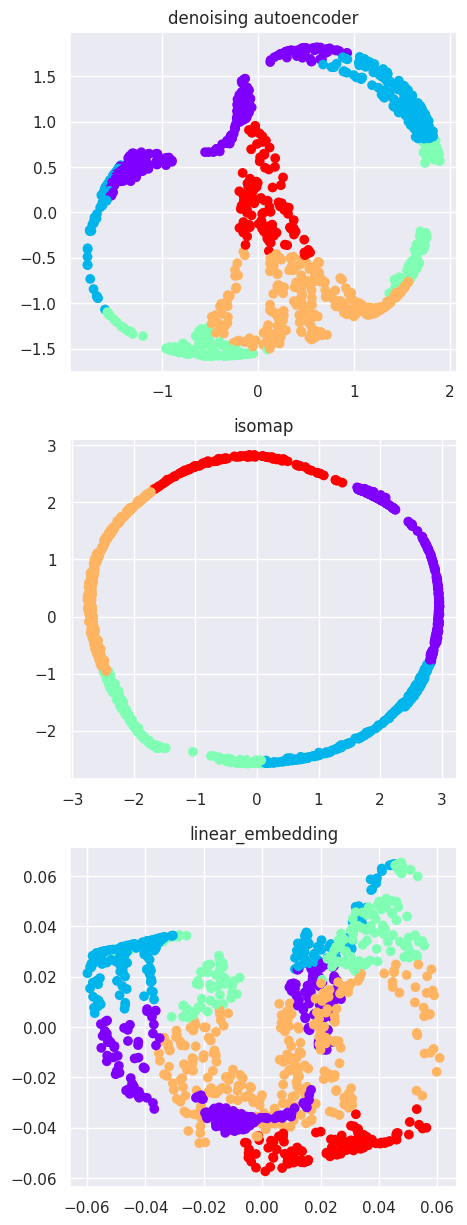

In [653]:
#@title Explore manifold learning
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns

def make_hello(N=1000, rseed=42):
  import seaborn as sns; sns.set();
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]


def unwind_manifold(datapoints, method):
  methods = {'lle': linear_embedding, 'mds': multidim_scaling, 'isomap': isomap}
  return methods[method](datapoints)

def roll(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
  b_y = b_x - 0.2
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  roulette = np.array([[(2 + p[0]) * np.cos(2 * p[0]), (2 + p[0]) * np.sin(2 * p[0]), 2.0 * p[1]] for p in params])
  return roulette

def s_curve(X):
  t = (X[:, 0] - 2) * 0.75 * np.pi
  x = np.sin(t)
  y = X[:, 1]
  z = np.sign(t) * (np.cos(t) - 1)
  return np.vstack((x, y, z)).T

def plane(X):
  p = np.array([[x[0], x[1], x[0] + x[1]] for x in X])
  return p

def mobius(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.1)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  mobius = np.array([[(1.0 + p[1]/2.0 * np.cos(p[0]/2)) * np.cos(p[0]), (1.0 + p[1]/2.0 * np.cos(p[0]/2)) * np.sin(p[0]), p[1]/2.0 * np.sin(p[0]/2)] for p in params])
  return mobius

def cylinder(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.1)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  cylinder = np.array([[2.0 * np.cos(p[0]), 2.0 * np.sin(p[0]), p[1]] for p in params])
  return cylinder

def helicoid(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  helicoid = np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[0]] for p in params])
  return helicoid

def cone(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
  b_y = b_x - 0.2
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  cone = np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[1]] for p in params])
  return cone

def transform_to_3d(x, manifold):
  funcs = {'s_curve': s_curve, 'mobius': mobius, 'cylinder': cylinder,
           'helicoid': helicoid, 'cone': cone, 'custom': custom, 'plane': plane,
           'roll': roll}
  return funcs[manifold](x)

X = make_hello(1024)
X = mobius(X)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
colors = ['rgb(' + np.array2string(c[:-1], formatter={'float_kind':lambda x:  "%.0f" % (x * 255)}, separator=',')[1:-1] + ')' for c in colorize['cmap'](0.255*colorize['c'])]


X = cylinder(X)

isomap_2d = isomap(X)

lin = linear_embedding(X)

# гораздо быстрее и качество лучше
autoencoder = denoising_autoencoder(
  X,
  distance_importance=1,
  output_dim=2,
  noising_level=0.1,
  closest_items=10,
  epochs=64,
  seed=-10,
  batch_size=128,
  debug=False,
  hid_dim=64
)
plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
plt.scatter(autoencoder[:,0],autoencoder[:,1],**colorize)
plt.title('denoising autoencoder')
plt.subplot(3,1,2)
plt.scatter(isomap_2d[:,0],isomap_2d[:,1],**colorize)
plt.title('isomap')
plt.subplot(3,1,3)
plt.scatter(lin[:,0],lin[:,1],**colorize)
plt.title('linear_embedding')

#MNIST  

* Запустите следующий код, чтобы загрузить набор данных MNIST и добавить шум 

In [654]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()
data, target = digits.data, digits.target
data = np.random.normal(data, 5)

* Выполните следующие функции, чтобы уменьшить размеры `данных` до 3. Ожидается, что результат будет иметь вид `(1797, 3)`.

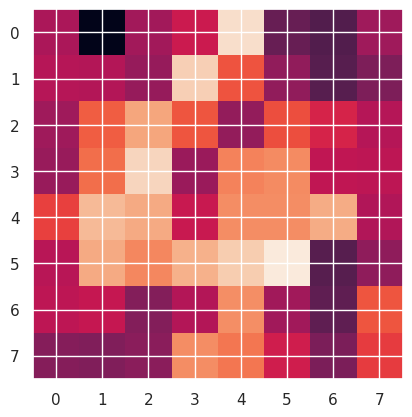

In [655]:
plt.imshow(data[np.random.choice(len(data),1)].reshape(8,8))

In [656]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

def projected_mds(data):
  return MDS(n_components=3).fit_transform(data)
def projected_isomap(data):
  return Isomap(n_components=3).fit_transform(data)
def projected_PCA(data):
  return PCA(n_components=3).fit_transform(data)

* Запустите код визуализации, чтобы увидеть результат.

In [ ]:
#@title Visualization
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cmap = {0: 'rgba(0,0,255,255)', 1: 'rgba(0,255,0,255)', 2: 'rgba(255,0,0,255)',
        3: 'rgba(0,0,128,255)', 4: 'rgba(0,128,0,255)', 5: 'rgba(128,0,255)',
        6: 'rgba(0,0,64,255)', 7: 'rgba(0,64,0,255)', 8: 'rgba(64,0,0,255)',
        9: 'rgba(0,0,0,255)'}
colors = [cmap[int(d)] for d in digits.target]

fig = make_subplots(rows=1, cols=4, specs=[[{"type": "scene"}]*4])

iso_proj = projected_isomap(data)
fig.add_trace(go.Scatter3d(x=iso_proj[:, 0], y=iso_proj[:, 1], z=iso_proj[:, 2],
                           mode='markers',
                           marker=dict(size=4, color=colors)),
              row=1, col=1)

pca_proj = projected_PCA(data)
fig.add_trace(go.Scatter3d(x=pca_proj[:, 0], y=pca_proj[:, 1], z=pca_proj[:, 2],
                           mode='markers',
                           marker=dict(size=4, color=colors)),
              row=1, col=2)

autoenc_proj = denoising_autoencoder(data,output_dim=3,batch_size=64,epochs=128,distance_importance=0.,noising_level=0.,hid_dim=256)
fig.add_trace(go.Scatter3d(x=autoenc_proj[:, 0], y=autoenc_proj[:, 1], z=autoenc_proj[:, 2],
                           mode='markers',
                           marker=dict(size=4, color=colors)),
              row=1, col=3)

mds_proj = projected_mds(data)
fig.add_trace(go.Scatter3d(x=mds_proj[:, 0], y=mds_proj[:, 1], z=mds_proj[:, 2],
                           mode='markers',
                           marker=dict(size=4, color=colors)),
              row=1, col=4)

fig.update_layout(width=1200, height=600, autosize=False,
                  title_text="3-component Isomap ,PCA, Autoencoder, MDS for MNIST",
                  scene={"xaxis": {"title": "component 1"},
                         "yaxis": {"title": "component 2"},
                         "zaxis": {"title": "component 3"}},
                  showlegend=False)

fig.show()

* разделить набор данных на поезд и тест 
* Создайте модели: 
   - любой классификатор (простой) 
   - PCA + любой классификатор
   - MDP + любой классификатор  
   - Изомап + любой классификатор 
* Обучите модели 
* Попробуйте сдеать классификацию

In [657]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn import svm


model = svm.SVC()

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True,random_state=32)
l_simple = svm.SVC().fit(X_train,y_train).predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(mds_proj, target, test_size=0.2, shuffle=True,random_state=32)
l_MDS = svm.SVC().fit(X_train,y_train).predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(iso_proj, target, test_size=0.2, shuffle=True,random_state=32)
l_isomap = svm.SVC().fit(X_train,y_train).predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(pca_proj, target, test_size=0.2, shuffle=True,random_state=32)
l_pca = svm.SVC().fit(X_train,y_train).predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(autoenc_proj, target, test_size=0.2, shuffle=True,random_state=32)
l_autoenc = svm.SVC().fit(X_train,y_train).predict(X_test)
# Note:  shapes should coincide with the shape of y_test

def get_results():
  return y_test, ['Simple model', 'mds', 'isomap', 'pca','autoencoder'], [l_simple, l_MDS, l_isomap, l_pca, l_autoenc]

* Запустите код визуализации, чтобы увидеть матрицы путаницы.

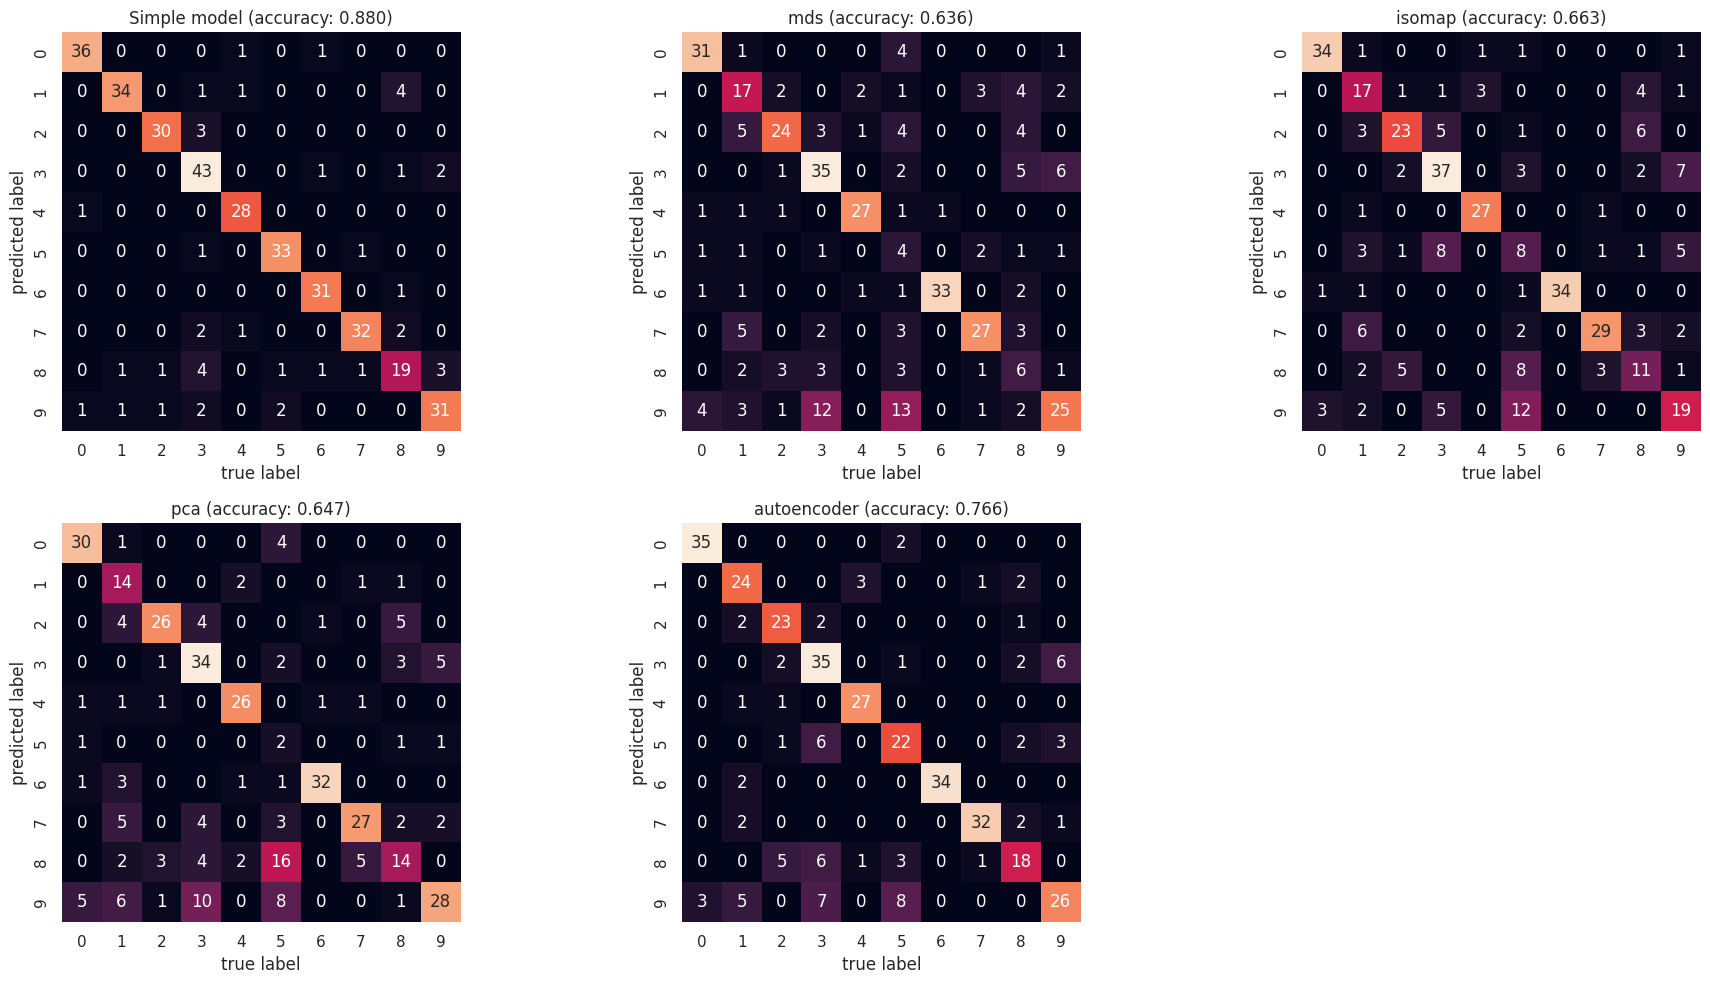

In [658]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

trg, names, labels = get_results()
num_plots = len(names)
fig = plt.figure(figsize=(20, 10))

for idx in range(num_plots):
  plt.subplot(2, 3, 1 + idx)
  mat = confusion_matrix(trg, labels[idx])
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[i for i in range(10)],
            yticklabels=[i for i in range(10)])
  plt.ylim(10.0, 0.0)
  plt.xlabel('true label')
  plt.ylabel('predicted label')

  plt.title(names[idx] + " (accuracy: " + str(accuracy_score(trg, labels[idx]))[:5] + ")")
  plt.tight_layout()